# Transfer Learning with keras pretrained model- Xception 
This model has weights that have been pretrained on imagenet
More layers are added on top of the model.
Could use data augmentation for better results- I did not try that yet
This still need to be fine-tuned for better performance

There are other pretrained models we can try if this doesnt seem like it is working

Another thing that could be done is geting all the mixed dog breed images to arrays


In [1]:
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Model, Input
from keras.preprocessing import image
from keras.applications import xception

Using TensorFlow backend.


In [2]:
import numpy as np
from sklearn import preprocessing

X_train = np.load(open('train_dataset.npy','rb'))
y_train = np.load(open('train_labels.npy','rb'))
X_test = np.load(open('test_dataset.npy','rb'))
y_test = np.load(open('test_labels.npy','rb'))
X_valid = np.load(open('valid_dataset.npy','rb'))
y_valid = np.load(open('valid_labels.npy','rb'))

y_valid = preprocessing.minmax_scale(y_valid, feature_range=(0,119))
y_train = preprocessing.minmax_scale(y_train, feature_range=(0,119))
y_test = preprocessing.minmax_scale(y_test, feature_range=(0,119))

from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, num_classes=None)
y_test = to_categorical(y_test, num_classes=None)
y_valid = to_categorical(y_valid, num_classes=None)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


In [3]:
bottleneck_features = np.load('DogXceptionData.npz')
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']

In [4]:
def extract_Xception(tensor):
    from keras.applications.xception import Xception, preprocess_input
    return Xception(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

On top of the pretrained model a fully connected layer with 1024 neurons and some Dropout is added.

In [5]:
NUM_CLASSES = 120
# create the base pre-trained model
base_model = xception.Xception(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
#Can try adding more layers
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer -- let's say we have NUM_CLASSES classes
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [6]:
import datetime
from keras.callbacks ModelCheckpoint
#Checkpoints still need to be added to model.fit call
# checkpoints
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# Authors suggest setting step_size = (2-8) x (training iterations in epoch)



Can try fine tuning more layers

In [ ]:
# #will freeze the first 116 layers and unfreeze the rest:
# for layer in model.layers[:116]:
#     layer.trainable = False
# for layer in model.layers[116:]:
#     layer.trainable = True

In [7]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
#Can try different optimizers like adam
optimizer = RMSprop(lr=0.001, rho=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=["accuracy"])


In [9]:
# train the model on the new data for a few epochs
BATCH_SIZE = 32
EPOCHS = 10

#Checkpoints still need to be added to model.fit call
model.fit(X_train, y_train, validation_data=(X_valid, y_valid),epochs=EPOCHS, batch_size=BATCH_SIZE)

                      
# hist = model.fit(X_train, y_train,
#                            #callbacks=[early_stopping, model_checkpoint],
#                            validation_data=(X_valid, y_valid),epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=callbacks_list)

Train on 16464 samples, validate on 2058 samples
Epoch 1/1
   32/16464 [..............................] - ETA: 2:28:08 - loss: 6.2844 - acc: 0.0000e+00

KeyboardInterrupt: 

In [ ]:
bst_val_acc = max(hist.history['val_acc'])
print("Best val acc: {:.1%}".format(bst_val_acc))

In [ ]:
#------uncomment here for checkpoints start
#filename = "yoursmallestlostweightfilehere"
#model.load_weights(filename)
#model.compile(loss='categorical_crossentropy', optimizer='adam')
#------end

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
# from keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(rotation_range=45,
#                                    width_shift_range=0.2,
#                                    height_shift_range=0.2,
#                                    shear_range=0.2,
#                                    zoom_range=0.25,
#                                    horizontal_flip=True,
#                                    fill_mode='nearest')

# test_datagen = ImageDataGenerator()

# Dog Breed Predictor
Im still working on figuring this out but here is what I have so far.

In [10]:
from scipy import ndimage, io, misc
from xml.dom import minidom
from matplotlib.pyplot import imshow
import cv2           
import matplotlib.pyplot as plt                        
%matplotlib inline        
from keras.preprocessing import image

In [34]:
def detect_dog(model, image_path):
    i=image.load_img(image_path,target_size=(224,224))
    x = image.img_to_array(i).shape
#     print(x)
    x = [1+x]
    print(x)
    bottleneck_features = extract_Xception(x)
    predicted_vector = model.predict(bottleneck_features)
    return predicted_vector

In [31]:
def display_image(img_path):
    a = misc.imread(img_path)[:,:,:3]
    imshow(a)

In [32]:
def dog_prediction(img_path): 
    #if dog_detector(img_path):    
    display_image(img_path)
    prediction = detect_dog(model, img_path)
    print('What a cute... {} ! '.format(prediction))

ValueError: cannot reshape array of size 3 into shape (4,)

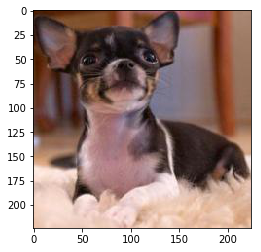

In [33]:
dog_prediction("/Users/juliagoyco/Desktop/Final_Deep_Learning/Images/n02085620-Chihuahua/n02085620_368.jpg")

In [ ]:
#display_image("/Users/juliagoyco/Desktop/Final_Deep_Learning/Images/n02085620-Chihuahua/n02085620_368.jpg")

In [35]:
detect_dog(model,"/Users/juliagoyco/Desktop/Final_Deep_Learning/Images/n02085620-Chihuahua/n02085620_368.jpg")

TypeError: unsupported operand type(s) for +: 'int' and 'tuple'